In [4]:
import os
import sys

In [5]:
import math
import logging
import glob
from pathlib import Path
import h5py

In [6]:
import numpy as np
import scipy as sp
import tensorflow as tf
import sklearn
import healpy as hp
import pymaster as nmt
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import PIL
import imageio
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

import dustvaeder
from dustvaeder.visualization import mplot
from dustvaeder import stats

%matplotlib inline

In [8]:
anim_file = '../reports/figures/trained_vae_t.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('../reports/figures/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

FileNotFoundError: The directory '/global/u1/b/bthorne/projects/DustVAEder/reports/figures' does not exist

In [3]:
cfg = {}
with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/prepared.h5", "r") as f:
    dset = f["cut_maps"][...]
    cfg.update(f["cut_maps"].attrs)
rescaled_dset = tf.image.per_image_standardization(dset)
print(rescaled_dset.shape)
#dset = tf.data.Dataset.from_tensor_slices(dset).shuffle(1000).batch(9).map(tf.image.per_image_standardization)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(1754, 256, 256, 1)


In [4]:
lat_dim = 256
kernel_size = 5 
model = began.CVAE(lat_dim, kernel_size)
model.load_weights("../models/vae.h5")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



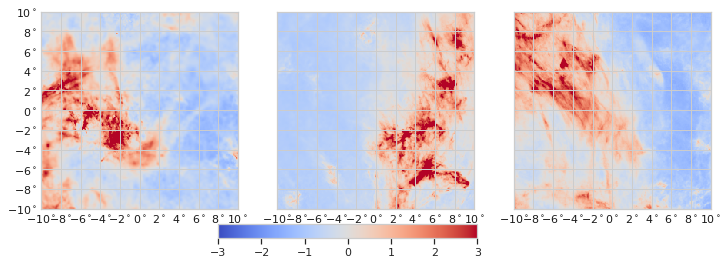

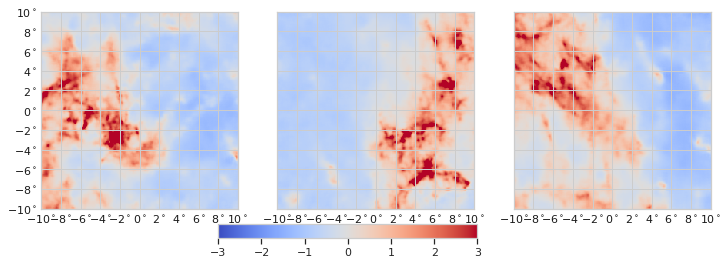

In [5]:
extent = (-cfg['ang_x'] / 2., cfg['ang_x'] / 2., -cfg['ang_y'] / 2., cfg['ang_y'] / 2.)

subset = rescaled_dset.numpy()[np.random.randint(0, rescaled_dset.shape[0], 3)]

mplot(subset[..., 0], cbar_range=[-3, 3], extent=extent);
mplot(model.decode(model.reparameterize(*model.encode(subset)))[..., 0], cbar_range=[-3, 3], extent=extent);

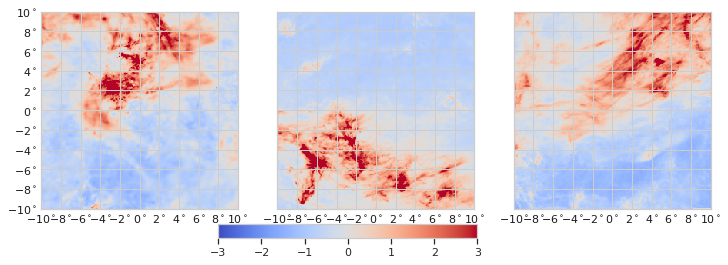

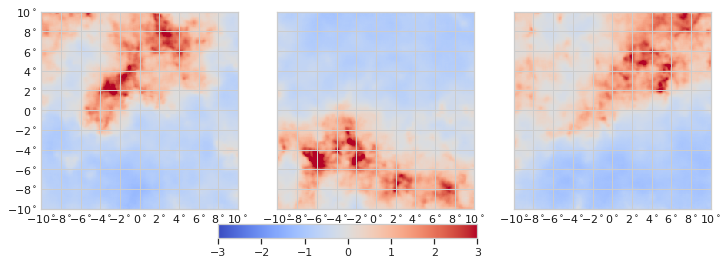

In [6]:
rot_img = sp.ndimage.rotate(subset, 90, axes=(1, 2))
mplot(rot_img[..., 0], cbar_range=[-3, 3], extent=extent)
mplot(model.decode(model.reparameterize(*model.encode(rot_img)))[..., 0], cbar_range=[-3, 3], extent=extent);

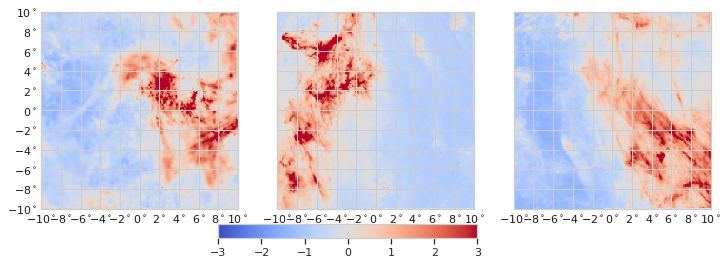

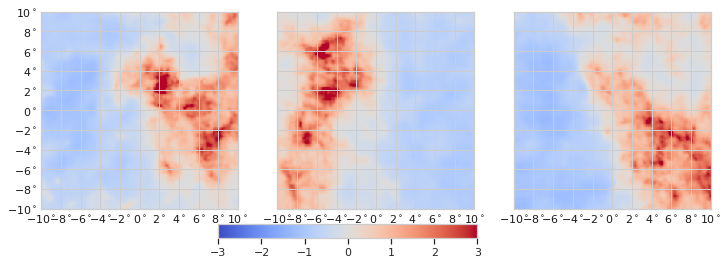

In [7]:
rot_img = sp.ndimage.rotate(subset, 180, axes=(1, 2))
mplot(rot_img[..., 0], cbar_range=[-3, 3], extent=extent)
mplot(model.decode(model.reparameterize(*model.encode(rot_img)))[..., 0], cbar_range=[-3, 3], extent=extent);

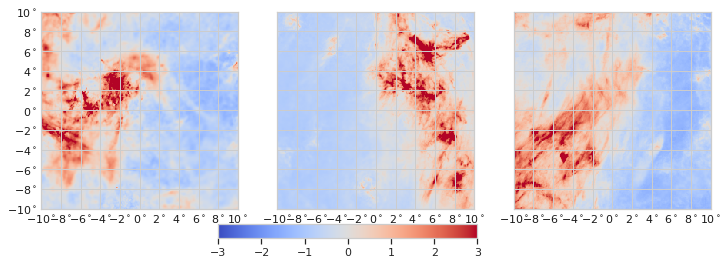

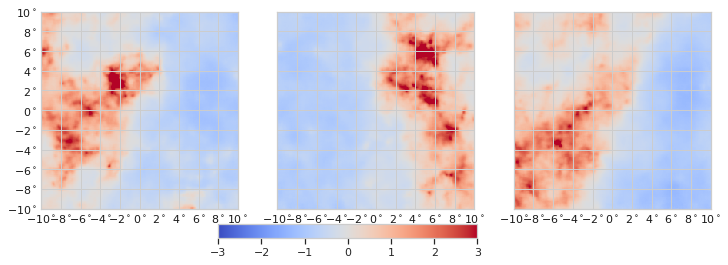

In [8]:
flip_img = subset[:, ::-1, ...]
mplot(flip_img[..., 0], cbar_range=[-3, 3], extent=extent)
mplot(model.decode(model.reparameterize(*model.encode(flip_img)))[..., 0], cbar_range=[-3, 3], extent=extent);

In [9]:
sample = model.decode(np.random.randn(100, 256))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [10]:
mask = stats.build_flat_mask(cfg['xres'], cfg['xres'], cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., 2.)
# evaluate the power spectrum of the sampled maps
nmtbin = stats.dimensions_to_nmtbin(cfg['xres'], cfg['yres'], cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., is_Dell=True)
autospectra = stats.batch_00_autospectrum(sample[..., 0].numpy(), cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., mask, nmtbin)

(1e-10, 1e-05)

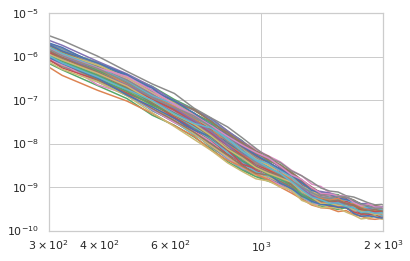

In [11]:
fig, ax = plt.subplots(1, 1)
for i in range(100):
    ax.loglog(nmtbin.get_effective_ells(), autospectra[i, 0, :])
ax.set_xlim(300, 2000)
ax.set_ylim(1e-10, 1e-5)

In [12]:
autospectra = stats.batch_00_autospectrum(rescaled_dset[..., 0].numpy(), cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., mask, nmtbin)

(1e-10, 1e-05)

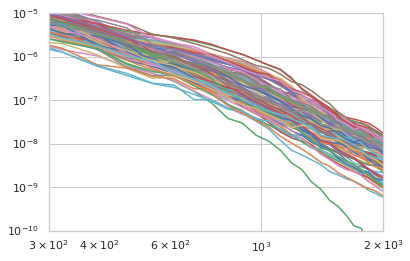

In [13]:
fig, ax = plt.subplots(1, 1)
for i in range(100):
    ax.loglog(nmtbin.get_effective_ells(), autospectra[i, 0, :])
ax.set_xlim(300, 2000)
ax.set_ylim(1e-10, 1e-5)

In [14]:
tsne = TSNE(n_components=2)

In [15]:
means, _ = model.encode(rescaled_dset[:200])
print(means.shape)


(200, 256)


In [16]:
x = tsne.fit_transform(means)
print(x.shape)

(200, 2)


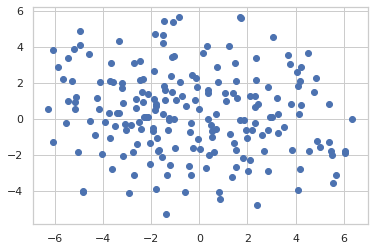

In [17]:
plt.scatter(x[:, 0], x[:, 1],)

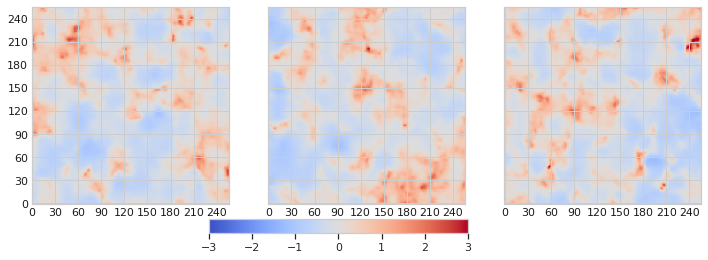

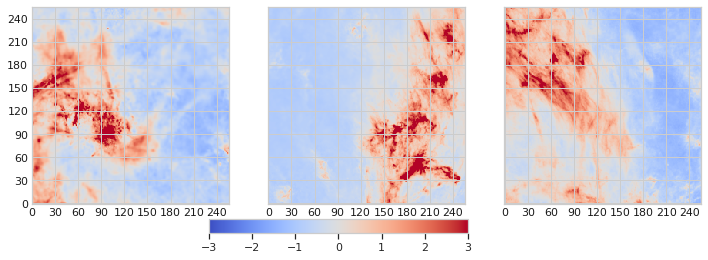

In [18]:
mplot(model.decode(np.random.randn(3, 256))[..., 0], cbar_range=[-3, 3]);
mplot(subset[..., 0], cbar_range=[-3, 3]);

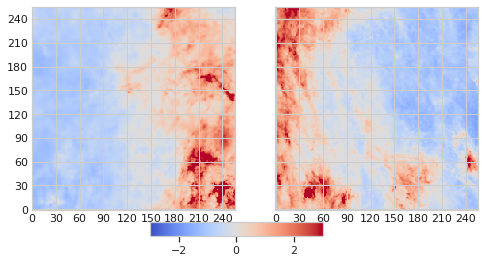

In [26]:
interp_samples = rescaled_dset.numpy()[np.random.randint(0, rescaled_dset.shape[0], 2)]
mplot(interp_samples[..., 0], cbar_range=[-3, 3]);

In [27]:
latent_encoding = model.encode(interp_samples)
latent_sample = model.reparameterize(*latent_encoding)

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b82efbefbd0>,
       dtype=object))

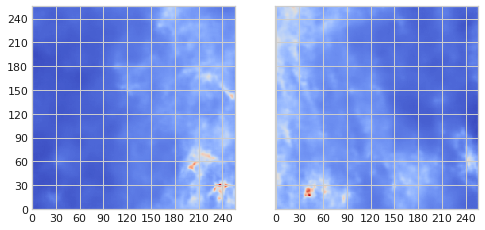

In [28]:
mplot(model.decode(latent_sample)[..., 0])

In [29]:
z1, z2 = latent_sample.numpy()

(array([ 1.,  7., 16., 38., 62., 68., 49.,  9.,  3.,  1.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ],
       dtype=float32),
 <a list of 10 Patch objects>)

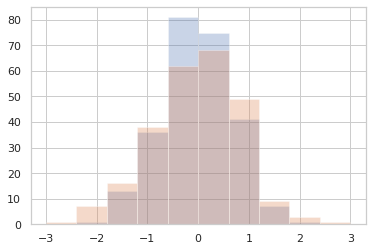

In [30]:
plt.hist(z1.flatten(), range=[-3, 3], bins=10, alpha=0.3)
plt.hist(z2.flatten(), range=[-3, 3], bins=10, alpha=0.3)

In [31]:
def interpolate_latent_vectors(z1, z2, num_samples=7):
    lamb = np.linspace(0, 1, num_samples)
    print(lamb)
    return z1[None, :] + (z2 - z1)[None, :] * lamb[:, None]

In [32]:
latent_samples = interpolate_latent_vectors(z1, z2)
print(latent_samples.shape)
interpolated_map = model.decode(latent_samples)
print(interpolated_map.shape)
plot_map = np.concatenate((interp_samples[0][None, ...], interpolated_map, interp_samples[-1][None, ...]))

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
(7, 256)
(7, 256, 256, 1)


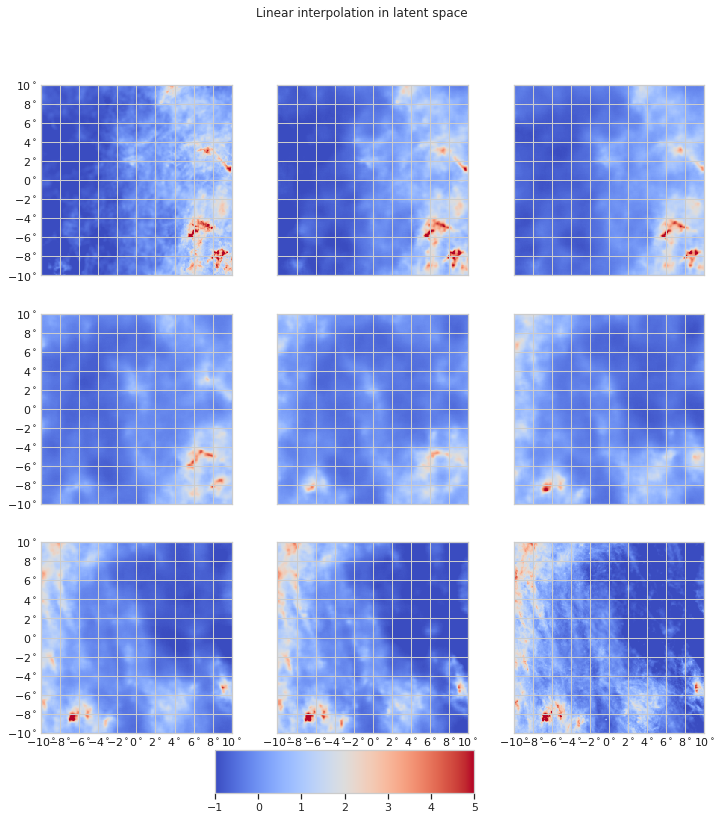

In [33]:
fig, axes = mplot(plot_map[..., 0], extent=extent, cbar_range=[-1, 5], title="Linear interpolation in latent space");
fig.savefig("../reports/figures/linear_latent_interpolation.png", bbox_inches='tight')

In [34]:
def spherical_interpolation(z1, z2, num_samples=7):
    lamb = np.linspace(0, 1, num_samples)
    theta = np.dot(z1, z2) * np.pi / 180.
    return np.sin(theta * (1 - lamb[:, None])) / np.sin(theta) * z1[None, :] + np.sin(lamb[:, None] * theta) / np.sin(theta) * z2[None, :]

In [38]:
lat_samples = spherical_interpolation(z1, z2, 14)

In [39]:
interpolated_map = model.decode(lat_samples)
print(interpolated_map.shape)
plot_map = np.concatenate((interp_samples[0][None, ...], interpolated_map, interp_samples[-1][None, ...]))

(14, 256, 256, 1)


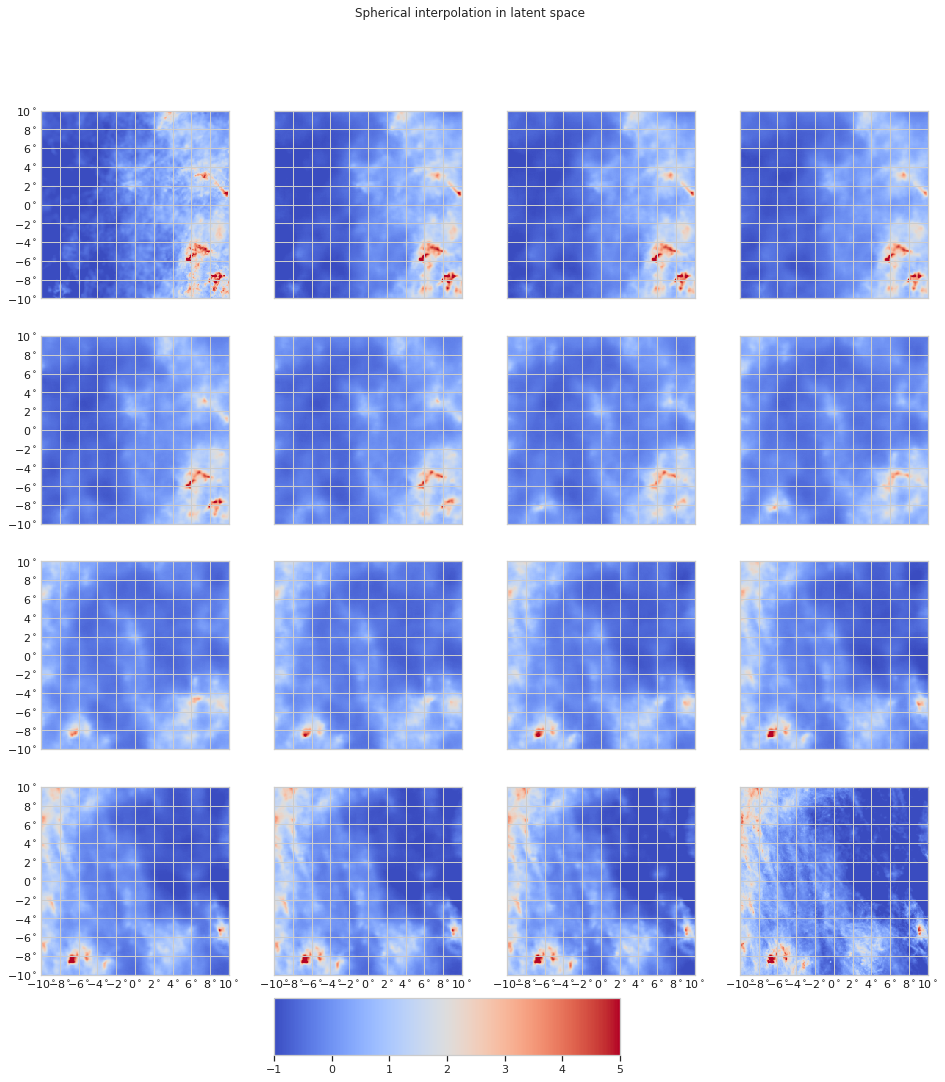

In [40]:
fig, axes = mplot(plot_map[..., 0], extent=extent, cbar_range=[-1, 5], title="Spherical interpolation in latent space");
fig.savefig("../reports/figures/spherical_latent_interpolation.png", bbox_inches='tight')

In [165]:
gan = tf.keras.models.load_model("../models/generator.h5")

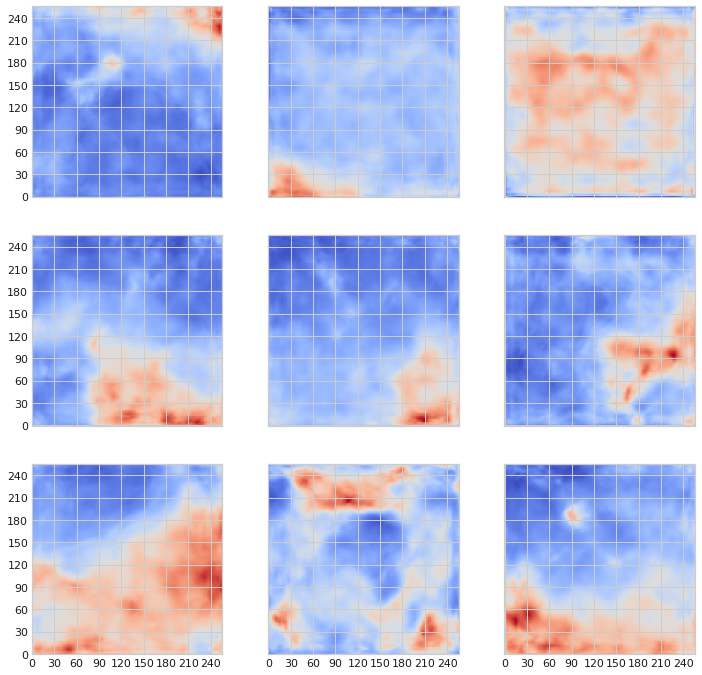

In [159]:
mplot(gan.predict(np.random.randn(9, 64))[..., 0]);

In [215]:
import tensorflow_probability as tfp
def l2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        genned_img = gan(x)[0, :, :, 0]
        loss_value = tf.linalg.norm(genned_img - interp_samples[0])
    jac = tape.gradient(loss_value,x)
    loss_value = tf.reshape(loss_value, [1])
    return loss_value,jac

x = tf.Variable(np.random.randn(1, 64).astype(np.float32))
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, tolerance=1e-05, max_iterations=2000)

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1a6b0510>,
       dtype=object))

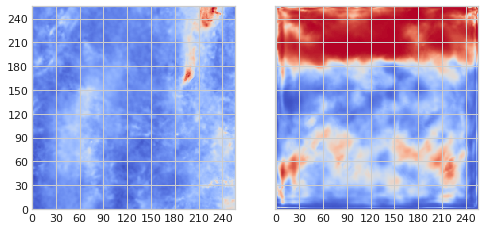

In [216]:
x_train_prediction = gan(opt.position)
mplot(np.concatenate((interp_samples[0][None, ...], x_train_prediction))[..., 0])

In [217]:
fwhm_in_pix = 60. / 5.
sigma = fwhm_in_pix / np.sqrt(8 * np.log(2))
subset_smo = np.array([gaussian_filter(sub[::-1, ::-1], sigma) for sub in subset[..., 0]])[..., None]

(<Figure size 864x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1a30bb50>,
       dtype=object))

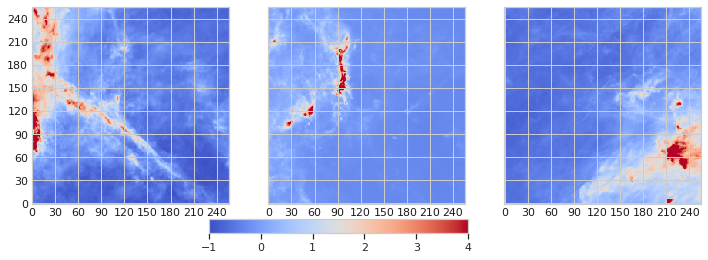

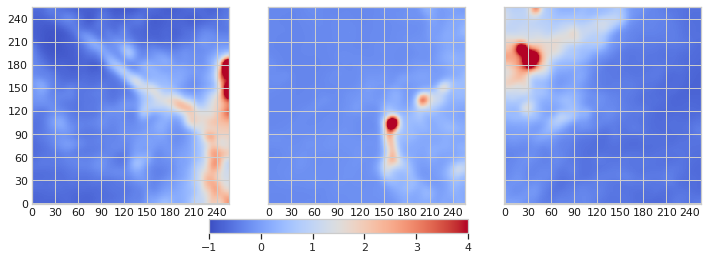

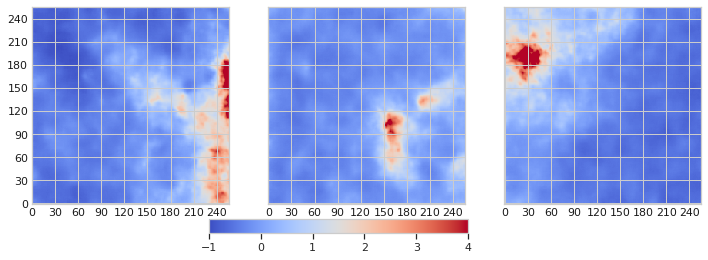

In [218]:
mplot(subset[..., 0], cbar_range=[-1, 4]);
mplot(subset_smo[..., 0], cbar_range=[-1, 4]);
mplot(model.decode(model.reparameterize(*model.encode(subset_smo)))[..., 0], cbar_range=[-1, 4])

In [ ]:
mask = stats.build_flat_mask(cfg['xres'], cfg['xres'], cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., 2.)
# evaluate the power spectrum of the sampled maps
nmtbin = stats.dimensions_to_nmtbin(cfg['xres'], cfg['yres'], cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., is_Dell=True)
autospectra = stats.batch_00_autospectrum(sample[..., 0].numpy(), cfg['ang_x'] * np.pi / 180., cfg['ang_y'] * np.pi / 180., mask, nmtbin)